In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle competitions download -c quora-question-pairs    ## change it 
!unzip \*.zip  && rm *.zip

Saving kaggle.json to kaggle.json
 52% 11.0M/21.2M [00:00<00:00, 54.6MB/s]
100% 21.2M/21.2M [00:00<00:00, 70.7MB/s]
  0% 0.00/4.95M [00:00<?, ?B/s]
100% 4.95M/4.95M [00:00<00:00, 45.3MB/s]
100% 173M/173M [00:00<00:00, 156MB/s]

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

3 archives were successfully processed.


<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats    

In [ ]:
train_data = pd.read_csv("train.csv")
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
train_data['question1'][0]

'What is the step by step guide to invest in share market in india?'

In [ ]:
train_data['question2'][0]

'What is the step by step guide to invest in share market?'

#### Type of machine learning problem

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

#### Performance metric 
- Log loss
- Binary confsion matrix

In [ ]:
#### Exploratory Data analysis

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


This dataset contains around 404k records in which question 1 and question 2 are the pair of questions.


question1 and question2 have some missing values.

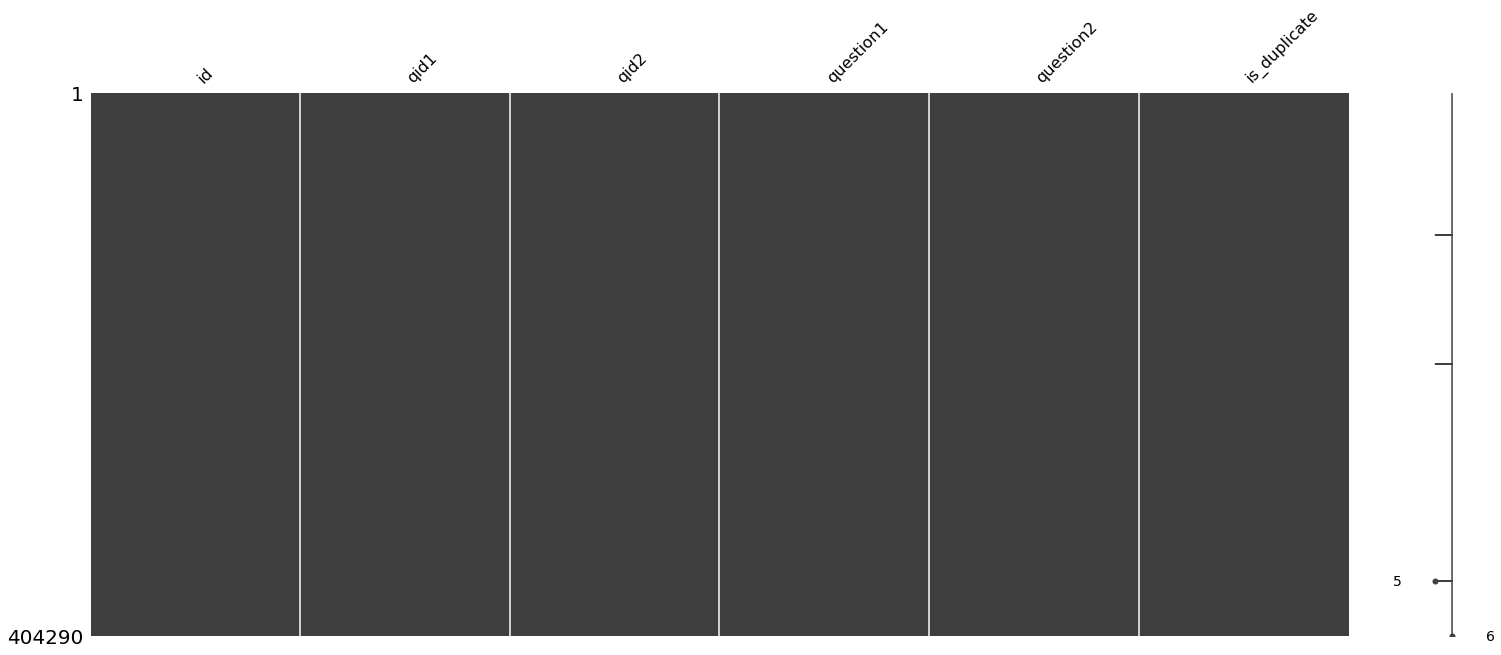

In [ ]:
import missingno as msno

msno.matrix(train_data)

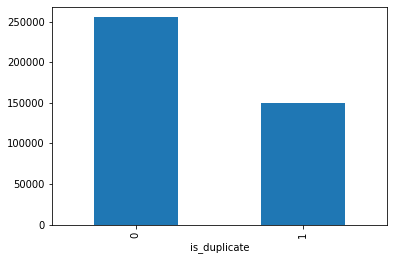

In [ ]:
train_data.groupby(['is_duplicate'])['id'].count().plot.bar()
plt.show()

In [ ]:
not_sim = (train_data['is_duplicate'].value_counts()[0] / train_data.shape[0] ) * 100
sim = (train_data['is_duplicate'].value_counts()[1] / train_data.shape[0] ) * 100

print("Questions pair which are not similiar [{} %]".format(round(not_sim,2)))
print("Questions pair which are similiar [{} %]".format(round(sim,2)))

Questions pair which are not similiar [63.08 %]
Questions pair which are similiar [36.92 %]


In [ ]:
# Number of unique questions

qids = pd.Series(train_data['qid1'].tolist() + train_data['qid2'].tolist())
unique_records = len(np.unique(qids))
qs_more_than_one_time = sum(qids.value_counts() > 1)


print("Total number of unique questions ==== [{}]".format(unique_records))
print("Numbr of questions that repeated ==== [{}]".format(qs_more_than_one_time))
print("Max Count that a question repeated == [{}]".format(max(qids.value_counts())))


Total number of unique questions ==== [537933]
Numbr of questions that repeated ==== [111780]
Max Count that a question repeated == [157]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


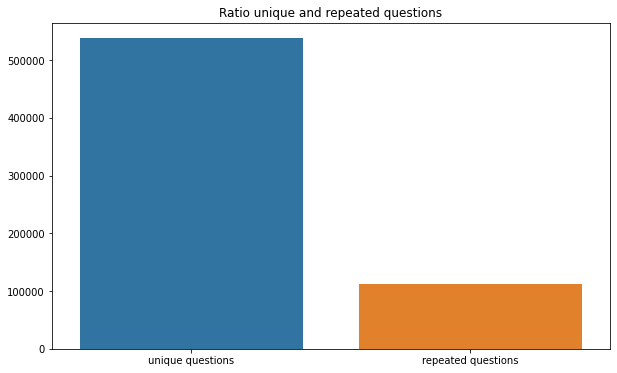

In [ ]:
x = ['unique questions', 'repeated questions']
y = [unique_records, qs_more_than_one_time]

plt.figure(figsize=(10, 6))
sns.barplot(x, y)
plt.title("Ratio unique and repeated questions")
plt.show()

In [ ]:
### checking for duplicates

train_data.duplicated(subset=['question1','question2', 'is_duplicate']).any()

False

In [ ]:

pair_duplicates = train_data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate quesion is [{}]".format(pair_duplicates.shape[0] - train_data.shape[0]))

Number of duplicate quesion is [0]


Maximum number of times a single question is repeated: [157]


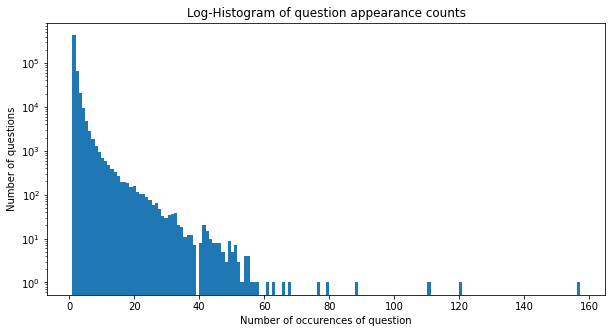

In [ ]:
## Number of Occurance of each question

plt.figure(figsize=(10, 5))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: [{}]'.format(max(qids.value_counts())))

In [ ]:
## checking for null values

null_records = train_data[train_data.isnull().any(1)]

In [ ]:
null_records

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
train_data = train_data.fillna(' ')

In [ ]:
train_data[train_data.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
data = train_data

In [ ]:
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')

In [ ]:
data['q1len'] = data['question1'].str.len()
data['q2len'] = data['question1'].str.len()

In [ ]:
data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))

In [ ]:
def normalized_word_Common(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)

In [ ]:
data['word_Total'] = data['q1_n_words'] + data['q2_n_words']

In [ ]:
def normalized_word_share(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
data['word_share'] = data.apply(normalized_word_share, axis=1)

In [ ]:
data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])

In [ ]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,66,14,12,10.0,26,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,51,8,13,4.0,21,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,73,14,10,4.0,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,50,11,9,0.0,20,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,76,13,7,2.0,20,0.100000,4,2


In [ ]:
# Analysis of new generated features

print("Minimum number of words in a question is [{} in question 1]".format(min(data['q1_n_words'])))
print("Minimum number of words in a question is [{} in question 2]".format(min(data['q2_n_words'])))
 
print("Count of question which contains only one word [{} in question 1]".format(data[data['q1_n_words']==1].shape[0]))
print("Count of question which contains only one word [{} in question 2]".format(data[data['q2_n_words']==1].shape[0]))

Minimum number of words in a question is [1 in question 1]
Minimum number of words in a question is [1 in question 2]
Count of question which contains only one word [66 in question 1]
Count of question which contains only one word [22 in question 2]


In [ ]:
data.to_csv("df_fe_without_preprocessing_train.csv", index=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


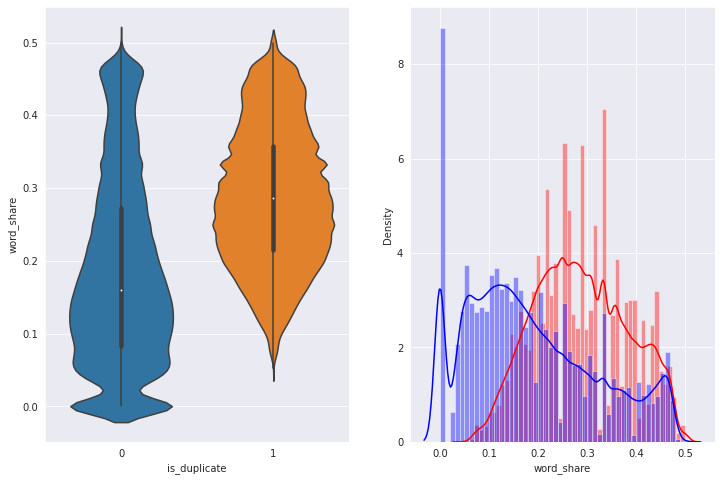

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_share', data=data[0:])

plt.subplot(1, 2 , 2)
sns.distplot(data[data['is_duplicate']==1.0]['word_share'][0:], label="1", color="red")
sns.distplot(data[data['is_duplicate']==0.0]['word_share'][0:], label="1", color="blue")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


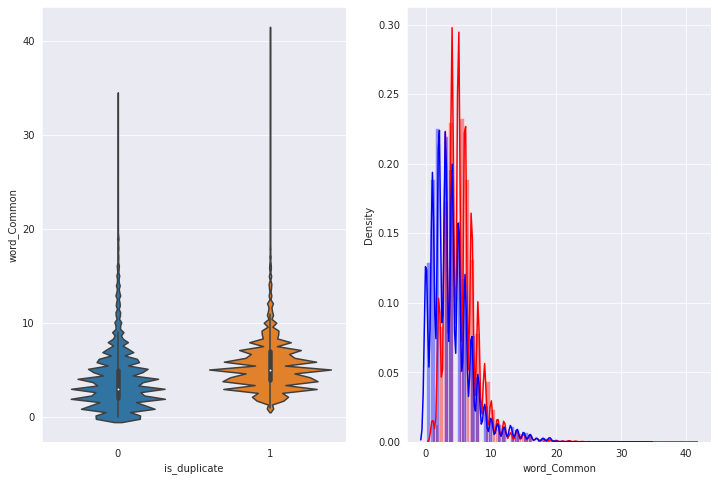

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_Common', data=data[0:])

plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate']==1.0]['word_Common'][0:], label="1", color='red')
sns.distplot(data[data['is_duplicate']==0.0]['word_Common'][0:], label="0", color='blue')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


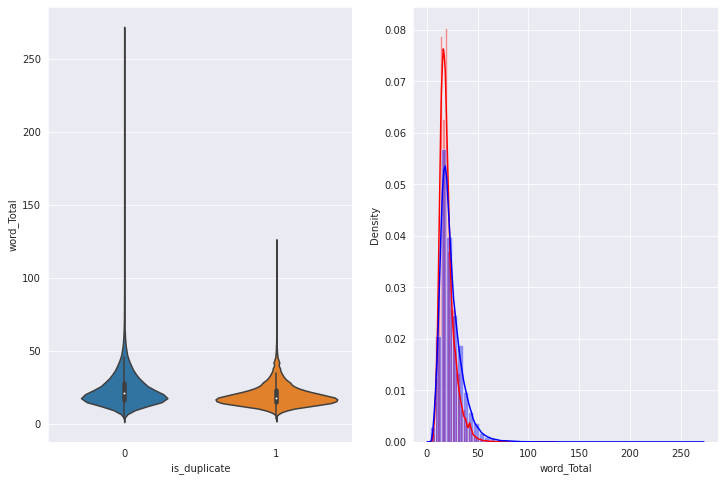

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_Total', data=data[0:])

plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate']==1.0]['word_Total'][0:], label='1', color='red')
sns.distplot(data[data['is_duplicate']==0.0]['word_Total'][0:], label='0', color='blue')
plt.show()

Distributions are fully overlaped that feature may not be useful for us let see later.

very highly overlapping

## Text Preprocessing

In [ ]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

- Removing html tags
- removing punchuation
- performing stemming
- Removing stopwords
- Expanding contracions etc

In [ ]:
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from os import path
from PIL import Image

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
!pip install distance

     |████████████████████████████████| 184kB 16.7MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=19e88ef64507329468791cbde096901d124f33f4dcae20b828fdebe017902e88
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [ ]:
import distance

In [ ]:
import nltk
nltk.download("stopwords")
STOP_WORDS = stopwords.words("english")
SAFE_DIV = 0.0001

def preprocess(x):
  x = str(x).lower()
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
        .replace("€", " euro ").replace("'ll", " will")

  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)
  porter = PorterStemmer()
  pattern = re.compile('\W')

  if type(x) == type(''):
    x  =re.sub(pattern, ' ', x)

  if type(x) == type(' '):
    x = porter.stem(x)
    example = BeautifulSoup(x)
    x = example.get_text()

  return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Advanced Feature Extraction (NLP and Fuzzy Features) 

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(q1, q2):
  token_features = [0.0]*10
  
  # Converting the Sentence into Tokens: 
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return token_features
  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
  
  #Get the stopwords in Questions
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
  
  # Get the common non-stopwords from Question pair
  common_word_count = len(q1_words.intersection(q2_words))
  
  # Get the common stopwords from Question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))
  
  # Get the common Tokens from Question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
  
  
  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  
  # Last word of both question is same or not
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
  
  # First word of both question is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])
  
  token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
  
  #Average Token Length of both Questions
  token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
  return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
  strs = list(distance.lcsubstrings(a, b))
  if len(strs) == 0:
    return 0
  else:
    return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
  # preprocessing each question
  df["question1"] = df["question1"].fillna("").apply(preprocess)
  df["question2"] = df["question2"].fillna("").apply(preprocess)

  print("token features...")
  
  # Merging Features with dataset
  
  token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
  
  df["cwc_min"]       = list(map(lambda x: x[0], token_features))
  df["cwc_max"]       = list(map(lambda x: x[1], token_features))
  df["csc_min"]       = list(map(lambda x: x[2], token_features))
  df["csc_max"]       = list(map(lambda x: x[3], token_features))
  df["ctc_min"]       = list(map(lambda x: x[4], token_features))
  df["ctc_max"]       = list(map(lambda x: x[5], token_features))
  df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
  df["first_word_eq"] = list(map(lambda x: x[7], token_features))
  df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
  df["mean_len"]      = list(map(lambda x: x[9], token_features))
  
  #Computing Fuzzy Features and Merging with Dataset
  
  # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
  # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
  # https://github.com/seatgeek/fuzzywuzzy
  print("fuzzy features..")

  df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
  # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
  # then joining them back into a string We then compare the transformed strings with a simple ratio().
  df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
  df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
  df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
  df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
  return df

In [ ]:
new_data = extract_features(data)

token features...
fuzzy features..


In [ ]:
new_data.to_csv("data_with_advanced_features.csv", index=False)

## Plotting word cloud

- Creating word cloud of dplicates and non duplicates question pairs
- we can observer the most frequent occuring words

In [ ]:
data_duplicate = new_data[new_data['is_duplicate'] == 1]
data_non_duplicate = new_data[new_data['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array like {{1, 2}, {3, 4}} into {1, 2 ,3 4}
p = np.dstack([data_duplicate["question1"], data_duplicate["question2"]]).flatten()
n = np.dstack([data_non_duplicate['question1'], data_non_duplicate['question2']]).flatten()

print("Number of data points in duplicate pairs are [{}]".format(len(p)))
print("Number of data points in non duplicate pair are [{}]".format(len(n)))

Number of data points in duplicate pairs are [298526]
Number of data points in non duplicate pair are [510054]


In [ ]:
from wordcloud import WordCloud, STOPWORDS


#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


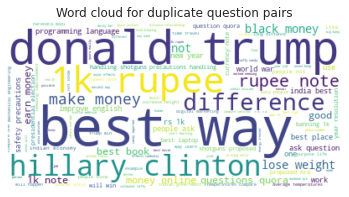

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(background_color='white', max_words=len(p), stopwords=stopwords)
wc.generate(textp_w)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for duplicate question pairs")
plt.show()

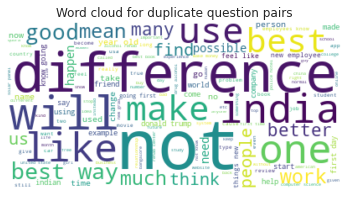

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(background_color='white', max_words=len(n), stopwords=stopwords)
wc.generate(textn_w)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for duplicate question pairs")
plt.show()

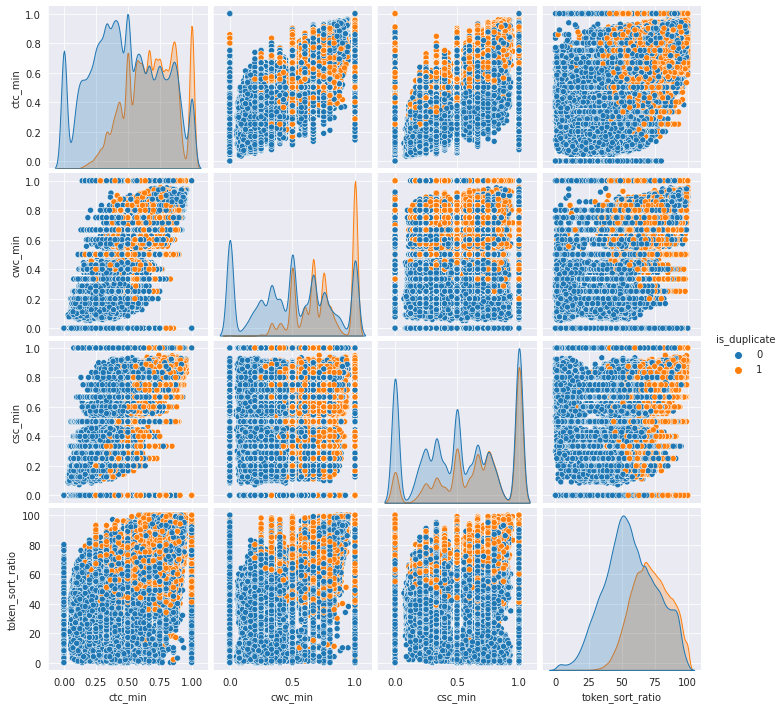

In [ ]:
sns.pairplot(new_data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = new_data[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne3d = TSNE(
    n_components=3, init='random', random_state=1,
    method='barnes_hut', verbose=2, n_iter=1000, angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 0.459s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.305s
[t-SNE] Iteration 50: error = 83.5267563, gradient norm = 0.0394963 (50 iterations in 7.671s)
[t-SNE] Iteration 100: error = 69.6281738, gradient norm = 0.0039121 (50 iterations in 3.787s)
[t-SNE] Iteration 150: error = 68.0893707, gradient norm = 0.0018105 (50 iterations in 3.490s)
[t-SNE] Iteration 200: error = 67.4536591, gradient norm = 0.0011591 (50 iterations in 3.586s)
[t-SNE] Iteration 250: error = 67.1198120, gradient norm = 0.0009729

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.tools as tls

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

#### Feauturizing text data with tdidf weighted word 2 vec

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
# import spacy
# nlp = spacy.load('en_core_web_sm')


In [ ]:

new_data = pd.read_csv("/content/drive/MyDrive/applied ai/quora /data_with_advanced_features.csv")
y = new_data['is_duplicate']
new_data = new_data.drop(columns=['is_duplicate'], axis=1)

In [ ]:
new_data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [ ]:
new_data = new_data.fillna(' ')

In [ ]:
new_data.shape

(404290, 31)

In [ ]:
vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vect1.fit_transform(new_data['question1'])

quest1_vec = vect1.transform(new_data['question1'].values)

vect2 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vect2.fit_transform(new_data['question1'])

quest2_vec = vect2.transform(new_data['question1'].values)

In [ ]:
new_data.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)

In [ ]:
from scipy.sparse import hstack

In [ ]:
final_data = hstack((new_data,quest1_vec, quest2_vec)).tocsr()

In [ ]:
final_data.shape

(404290, 116560)

In [ ]:
type(final_data)

scipy.sparse.csr.csr_matrix

In [ ]:
y.shape

(404290,)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True)

clf.fit(final_data, y)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
test_auc = clf.cv_results_['mean_test_score'] 
test_auc_std = clf.cv_results_['std_test_score']

In [ ]:
print('Best score: ',clf.best_score_)
print('k value with best score: ',clf.best_params_)
print('='*75)
print('Train AUC scores')
print(clf.cv_results_['mean_train_score'])
print('CV AUC scores')
print(clf.cv_results_['mean_test_score'])

Best score:  0.8022283993518939
k value with best score:  {'alpha': 1e-05}
Train AUC scores
[0.80956622 0.80816471 0.80751911 0.80591799 0.80517922 0.80333879
 0.80247329 0.80018963 0.79897982 0.79503641 0.79261058 0.78526543
 0.7814598  0.76688137 0.75231641 0.67027077 0.62313097 0.57805834
 0.55890936 0.54821913]
CV AUC scores
[0.8022284  0.80132825 0.80089891 0.79980372 0.79927947 0.79794411
 0.79730344 0.79557269 0.79464297 0.79155404 0.78962727 0.78358927
 0.78029902 0.76647471 0.75207755 0.67021015 0.62310493 0.57804894
 0.55890383 0.54821537]


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(new_data, y, stratify=y, test_size=0.3)

In [ ]:
print("[Distribuion of output variable in train data]")
print("Class 0: ", y_train.value_counts()[0]/len(y_train))
print("Class 1: ", y_train.value_counts()[1]/len(y_train))
print("="*70)
print("[Distribution of output variable in test data]")
print("Class 0: ", y_test.value_counts()[0]/len(y_test))
print("Class 1: ", y_test.value_counts()[1]/len(y_test))

[Distribuion of output variable in train data]
Class 0:  0.6308025003268517
Class 1:  0.36919749967314835
[Distribution of output variable in test data]
Class 0:  0.6308013224830361
Class 1:  0.3691986775169639


In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  C = confusion_matrix(y_test, y_pred)

  A = (C.T / C.sum(axis=1)).T

  B = (C / C.sum(axis=0))


  plt.figure(figsize=(20,4))
  cmap = sns.color_palette("rocket", as_cmap=True)

  labels = [1,2]

  plt.subplot(1, 3, 1)
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted class")
  plt.ylabel("Actual class")
  plt.title("Confusion matrix", fontsize = 15)

  plt.subplot(1, 3, 2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.title("Precision matrix")

  plt.subplot(1, 3, 3)
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.title("Recall matrix")

  plt.show()

Log loss on test data using random model 0.8859270545185619


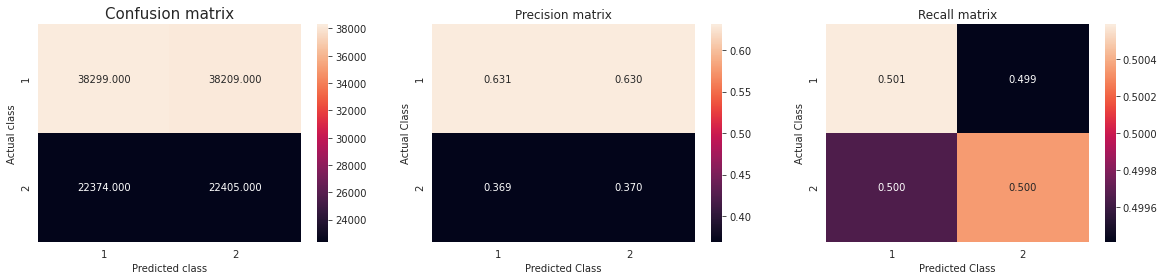

In [ ]:
### Building a random model

predicted_y = np.zeros((len(y_test), 2))
for i in range(len(y_test)):
  rand_probs = np.random.rand(1, 2)
  predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on test data using random model", log_loss(y_test, predicted_y, eps=1e-15))

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
## logistic regression with hyperparameter tunning

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, log_loss
from sklearn.metrics import confusion_matrix


alpha = [10**x for x in range(-3, 2)]

log_error_array = []
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=1, n_jobs=-1)
  clf.fit(X_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(X_train, y_train)
  y_pred = sig_clf.predict_proba(X_test)
  log_error_array.append(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))
  print('alpha [{}] | log loss [{}]'.format(i,log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)))


# plotting cv error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='r')
for i, txt in enumerate(np.round(log_error_array, 3)):
  ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross Validation error for each alpha")
plt.xlabel("alpha")
plt.ylabel("Error measure")
plt.show()

# training the model on the best value of alpha
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

alpha [0.001] | log loss [0.4568505742871835]
alpha [0.01] | log loss [0.437966919242232]
alpha [0.1] | log loss [0.4530390846409418]
alpha [1] | log loss [0.49390944702019524]
alpha [10] | log loss [0.5463603811424689]


NameError: ignored

In [ ]:
lr = LogisticRegression()
param = {'penalty':('l2', 'l1', 'elastic'), 'C':[0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(lr, param, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ('l2', 'l1', 'elastic')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
y_pred = clf.predict_proba(X_test)
print(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))

0.448403634399022


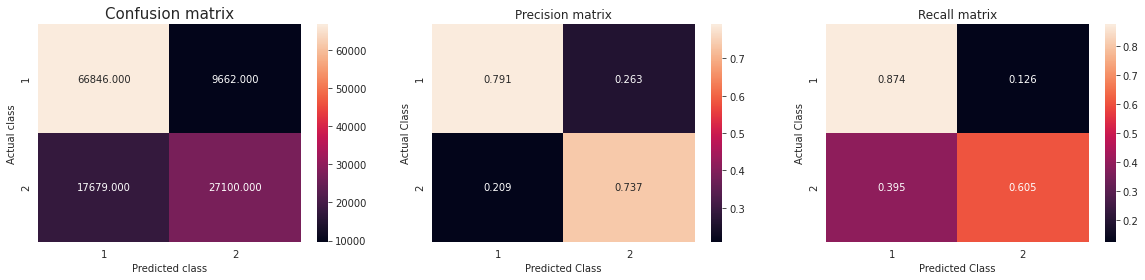

In [ ]:
predicted_y = np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)


In [ ]:
from scipy.stats import uniform

lr = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)

distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1','elasticnet'])
clf = RandomizedSearchCV(lr, distributions, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'C': 2.195254015709299, 'penalty': 'l1'}

In [ ]:
y_pred = clf.predict_proba(X_test)
print(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))

0.450255169333529


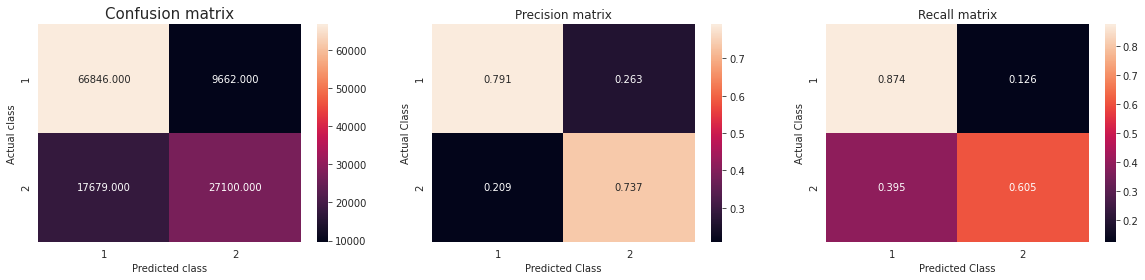

In [ ]:
predicted_y = np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

alpha [0.001] | log loss [0.4453534957277488]
alpha [0.01] | log loss [0.46723194955997327]
alpha [0.1] | log loss [0.47077172411714074]
alpha [1] | log loss [0.5766745157003242]
alpha [10] | log loss [0.6427148847496792]


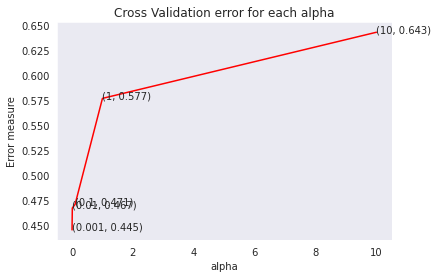

For values of best alpha =  0.001 The train log loss is: 0.4468456150138804
For values of best alpha =  0.001 The test log loss is: 0.4453534957277488
Total number of data points : 121287


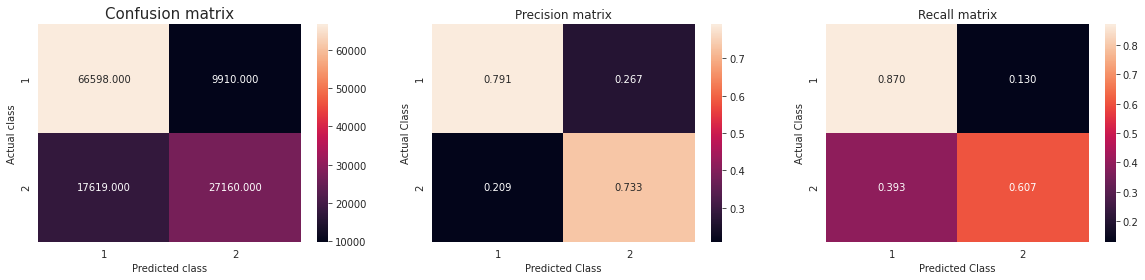

In [ ]:
## Linear SVM

alpha = [10**x for x in range(-3, 2)]

log_error_array = []
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=1, n_jobs=-1)
  clf.fit(X_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(X_train, y_train)
  y_pred = sig_clf.predict_proba(X_test)
  log_error_array.append(log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))
  print('alpha [{}] | log loss [{}]'.format(i,log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)))


# plotting cv error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='r')
for i, txt in enumerate(np.round(log_error_array, 3)):
  ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross Validation error for each alpha")
plt.xlabel("alpha")
plt.ylabel("Error measure")
plt.show()

# training the model on the best value of alpha
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l1', loss='hinge', random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of best alpha =  0.001 The train log loss is: 0.446159186647505
For values of best alpha =  0.001 The test log loss is: 0.4446869773051111
Total number of data points : 121287


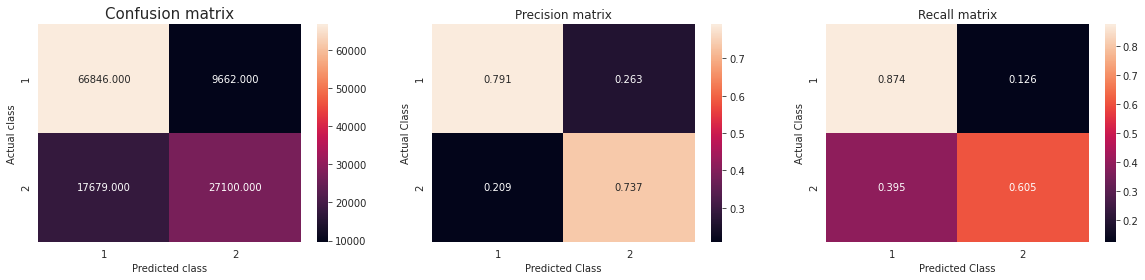

In [ ]:
# training the model on the best value of alpha

clf = SGDClassifier(alpha = 0.0001, penalty='l1', loss='hinge', random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
## logistic regression with hyperparameter tunning

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, log_loss

In [ ]:
2+2

4

In [ ]:
import xgboost as xgb

param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'logloss'
param['eta'] = 0.02
param['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(param, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
xgdmat = xgb.DMatrix(X_train, y_train)
predict_y = bst.predict(d_test)

print("The test log loss is :", log_loss(y_test, predict_y, eps=1e-15))

[0]	train-logloss:0.684862	valid-logloss:0.684862
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615328	valid-logloss:0.615385
[20]	train-logloss:0.564607	valid-logloss:0.564783
[30]	train-logloss:0.526567	valid-logloss:0.526909
[40]	train-logloss:0.497256	valid-logloss:0.497719
[50]	train-logloss:0.474106	valid-logloss:0.474613
[60]	train-logloss:0.455769	valid-logloss:0.456377
[70]	train-logloss:0.441072	valid-logloss:0.441791
[80]	train-logloss:0.429203	valid-logloss:0.429976
[90]	train-logloss:0.419562	valid-logloss:0.420404
[100]	train-logloss:0.411546	valid-logloss:0.412453
[110]	train-logloss:0.404791	valid-logloss:0.405729
[120]	train-logloss:0.399216	valid-logloss:0.400203
[130]	train-logloss:0.39449	valid-logloss:0.395537
[140]	train-logloss:0.390416	valid-logloss:0.391514
[150]	train-logloss:0.387	valid-logloss:0.388179
[160]	train-logloss:0.383968	val

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 1)

param_grid = {'n_estimators': [15, 25, 50, 100],
              'colsample_bytree': [0.65, 0.75, 0.80],
              'max_depth': [8, 12, 16, 20, 24],
              'reg_alpha': [1],
              'reg_lambda': [1, 2, 5],
              'subsample': [0.50, 0.75, 1.00],
              'learning_rate': [0.01, 0.1, 0.5],
              'gamma': [0.5, 1, 2, 5],
              'min_child_weight': [0.01],
              'sampling_method': ['uniform']}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train, y_train)
y_pred = best_clf_xgb.predict(X_test)
print(log_loss(y_test, y_pred, eps=1e-15))


Fitting 3 folds for each of 6480 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.4min


KeyboardInterrupt: ignored